# Machine Vision 2022/23 - Assignment 3: Line Fitting

Consider the image `res/postit2g.png` from the previous assignment. Where we already identified edge pixels
using canny edge detection and parametric lines using the hough transform.

In this assignment we will continue fitting parametric lines using different approaches.

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.color
%matplotlib inline

#### Part 1: Line Fitting using Total Least Squares

##### Preparation

First, visualize the image and understand its shape

gray_img shape [v,u]: (383, 640)


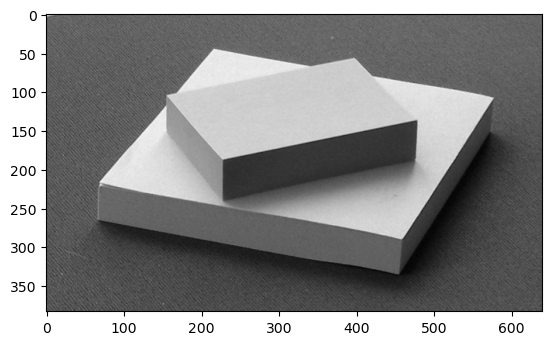

In [3]:
# @student: visualize image and print its shape
gray_img = skimage.io.imread("res/postit2g.png")
print(f"gray_img shape [v,u]: {gray_img.shape}")
plt.imshow(gray_img, cmap="gray")

The image is a grayscale image, hence it has only one color dimension/channel.
However, we want to visualize the found lines in red.
Therefore, we need to convert it to RGB color space

color_img shape [v,u,c]: (383, 640, 3)


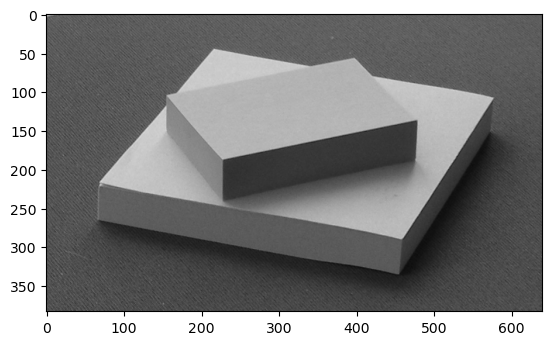

In [4]:
color_img = skimage.color.gray2rgb(gray_img)  # skimage.color.gray2rgb
print(f"color_img shape [v,u,c]: {color_img.shape}")
plt.imshow(color_img)

The file `res/edge_pixels.npy` contains 19 lists, where each list represents a dominant edge.

In [82]:
lists_of_edgepixels = np.load("res/edge_pixels.npy", allow_pickle=True)

# Each list contains of a different amount of pixels, where each pixel consists of an u and v coordinate
print(f"pixels in first list: {lists_of_edgepixels[0].shape}")
print(f"pixels in second list: {lists_of_edgepixels[1].shape}")

pixels in first list: (57, 2)
pixels in second list: (251, 2)


In [83]:
u3 = [x[0] for x in lists_of_edgepixels[2]]
v3 = [x[1] for x in lists_of_edgepixels[2]]
u3, v3

([227,
  226,
  225,
  224,
  223,
  222,
  222,
  221,
  220,
  219,
  218,
  217,
  216,
  215,
  214,
  213,
  212,
  212,
  211,
  210,
  209,
  208,
  207,
  206,
  205,
  204,
  203,
  203,
  202,
  201,
  200,
  199,
  198,
  197,
  197,
  196,
  195,
  194,
  193,
  192,
  191,
  190,
  190,
  189,
  188,
  187,
  186,
  185,
  184,
  184,
  183,
  182,
  181,
  180,
  179,
  179,
  178,
  177,
  176,
  175,
  174,
  173,
  172,
  172,
  171,
  170,
  169,
  168,
  168,
  167,
  166,
  165,
  164,
  163,
  162,
  162,
  161,
  160,
  159,
  158,
  157],
 [187,
  186,
  185,
  184,
  183,
  182,
  181,
  180,
  179,
  178,
  177,
  176,
  175,
  174,
  173,
  172,
  171,
  170,
  169,
  168,
  167,
  166,
  165,
  164,
  163,
  162,
  161,
  160,
  159,
  158,
  157,
  156,
  155,
  154,
  153,
  152,
  151,
  150,
  149,
  148,
  147,
  146,
  145,
  144,
  143,
  142,
  141,
  140,
  139,
  138,
  137,
  136,
  135,
  134,
  133,
  132,
  131,
  130,
  129,
  128,
  127,
  126

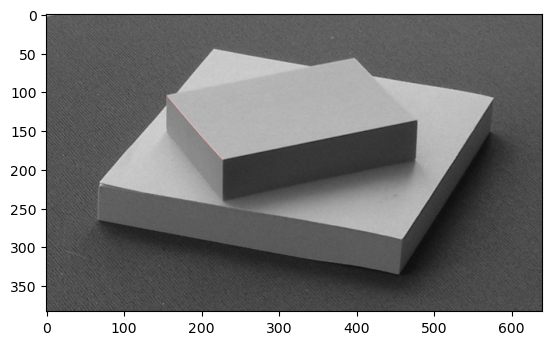

In [84]:
# @student: List the u pixels and the v pixels of the third list of edge pixels
# In this list the index of u coordinate is 0 and the index of the coordinate v=1
u3 = [x[0] for x in lists_of_edgepixels[2]]
v3 = [x[1] for x in lists_of_edgepixels[2]]

# copy color_img and change the color of edge pixels to red
# it is important to use copy.deepcopy to copy the contents of the array (image)
color_img_edge3 = copy.deepcopy(color_img)

# @student: change the color of u0 and v0 to red
color_img_edge3[v3, u3, 0] = 255
plt.imshow(color_img_edge3)
plt.show()

|##### Calculation

Using a list of edge pixels we can fit a line through these using the total least squares aproach.

In [85]:
def fit_line_total_least_squares(edgepixels):
    # @student: Calculate alpha, beta, gamma
    u = np.array([x[0] for x in edgepixels])
    v = np.array([x[1] for x in edgepixels])
    N = len(u)

    u_sum = np.sum(u)
    v_sum = np.sum(v)
    u_sum_2 = np.sum(u**2)
    v_sum_2 = np.sum(v**2)
    uv_sum = np.sum(u * v)
    alpha = u_sum_2 - 1/N*(u_sum**2)
    beta = uv_sum - 1/N*(u_sum*v_sum)
    gamma = v_sum_2 - 1/N*(v_sum**2)

    # Build up matrix M and calculate its smallest eigenvector (var: evec)
    M = np.ndarray(shape=(2,2))
    M[0,0] = alpha
    M[0,1] = beta
    M[1,0] = beta
    M[1,1] = gamma
    evals, evecs = np.linalg.eig(M) # calculate eigenvalues / eigenvectors
    eigen_sorted = np.argsort(evals) # sort eigenvalues
    evec = evecs[:, eigen_sorted[0]] # get eigenvector with the smallest eigenvalue

    # @student: Calculate c
    c = -sum(evec[0] * u + evec[1] * v) / N

    return evec, c

In [86]:
# for each list of edge pixels we create an array containing the line parameters
# Therefore, each entry consists of (0: n0, 1: n1, 2: c)
lines = np.ndarray(shape=(len(lists_of_edgepixels), 3))
print(f"lines shape: {lines.shape}")
for idx, edgepixels in enumerate(lists_of_edgepixels):
    n, c = fit_line_total_least_squares(edgepixels)
    lines[idx] = [n[0], n[1], c]

lines shape: (19, 3)


In order to visualize the line we create an array with values ranging from `0` to `max(u)`
Afterwards, we apply the line equation for each u in this range

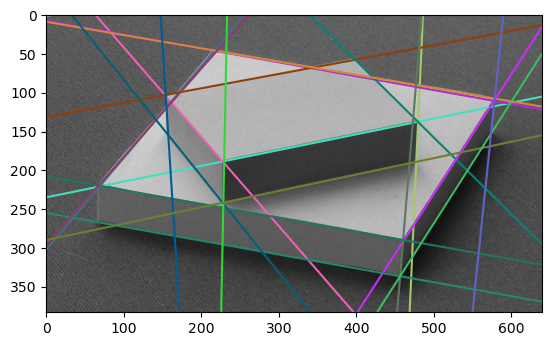

In [87]:
# @student: create span for u
u = np.arange(0, gray_img.shape[1])
for line in lines:
    # @student: apply line equation to calculate v based on the line parameters and u
    v = -(line[2] + line[0] * u) / line[1]

    random_color = np.random.rand(3,)
    plt.plot(u, v, c=random_color)

plt.imshow(color_img)
plt.xlim(0, color_img.shape[1]) # limit u axis to image dimension
plt.ylim(color_img.shape[0], 0) # limit v axis to image dimension
plt.show()

We successfully applied total least squares in order to estimate line parameters from a list of pixels.
However, we don't know the start and end of the line within the image yet.
In order to do so, we project each edge pixel to the computed line and take the first and last projected point as start and end.

In [98]:
a = np.array([[0, 1],[2, 3], [7, 9], [4, 5]])
np.argmax(a, axis = 1)

array([1, 1, 1, 1])

In [5]:
def calculate_start_end(*, line, edgepixels):
    # @student: project edgepixels to the line
    u = np.array([x[0] for x in edgepixels])
    v = np.array([x[1] for x in edgepixels])
    n1 = line[0]
    n2 = line[1]
    c = line[2]
    d = n1 * u + n2 * v + c
    # projection = np.array[(n2**2*u - n1*n2*v - n1*c) / (n1**2+n2**2), (n1**2*v - n1*n2*u - n2*c) / (n1**2+n2**2)]
    projection = ...

    min_idx, _ = np.argmin(projection, axis=1)
    max_idx, _ = np.argmax(projection, axis=1)

    return [projection[0,min_idx], projection[0,max_idx]], [projection[1,min_idx], projection[1,max_idx]]

for idx, edgepixels in enumerate(lists_of_edgepixels):
    line = lines[idx]
    line_start_u, line_end_v = calculate_start_end(line=line, edgepixels=edgepixels)
    random_color = np.random.rand(3,)
    plt.plot(line_start_u, line_end_v, c=random_color, marker="o", mfc='none')
plt.imshow(color_img)
plt.show()

NameError: name 'lists_of_edgepixels' is not defined

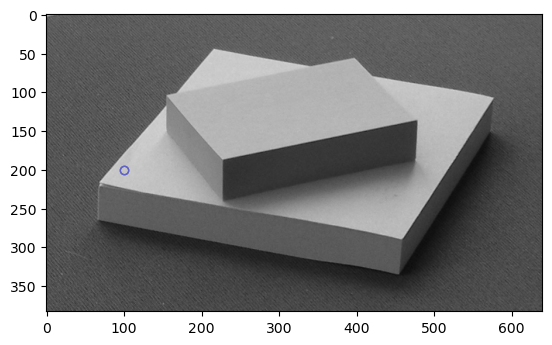

In [91]:
plt.plot([100, 100], [200, 200], c=random_color, marker="o", mfc='none')
plt.imshow(color_img)

#### Part 2: Line Fitting using RANSAC

In comparison to total least squares, RANSAC is robust against outliers. In this exercise you will implement RANSAC and compare it to total least squares.

In [6]:
def find_two_random_pixels(*, edgepixels):
    # @student: find two different random pixels within the edgepixels array
    indexs = np.arange(0, len(edgepixels))
    two_random_pixels = np.random.choice(indexs, size=2, replace=False)
    return edgepixels[two_random_pixels[0]], edgepixels[two_random_pixels[1]]

In [7]:
def calculate_nc(*, p1, p2):
    # @student: based on two pixels p1 and p2 calculate the parameters n,c (line in normal form) between p1 and p2
    n_1 = np.array(1)
    n_2 = -(p1[0] - p2[0]) / (p1[1] - p2[1])
    n_1 = n_1 / np.sqrt(n_1**2 + n_2**2)
    n_2 = n_2 / np.sqrt(n_1**2 + n_2**2)
    n = np.array((n_1, n_2))
    c = - sum(n * p1)

    return n, c

In [8]:
def calculate_num_inliers(*, edgepixels, n, c, threshold):
    # @student: Calculate the number on inliers
    num_of_inliers = 0
    for edgepixel in edgepixels:
        u = edgepixel[0]
        v = edgepixel[1]
        d = np.abs(u*n[0]+v*n[1]+c)
        if d <= threshold:
            num_of_inliers = num_of_inliers + 1
    return num_of_inliers

In [9]:
def fit_line_ransac(*, edgepixels, k, threshold):
    best_num_inliers = 0
    best_n = None
    best_c = None
    best_p1 = None
    best_p2 = None

    # iterate k times
    for _ in range(k):
        # Generate two random pixels from the edgepixels
        p1, p2 = find_two_random_pixels(edgepixels=edgepixels)

        # Calculate n , c
        n, c = calculate_nc(p1=p1, p2=p2)

        # Calculate how many points are inliers within the threshold t based on the distance to the line
        num_inliers = calculate_num_inliers(edgepixels=edgepixels, n=n, c=c, threshold=threshold)

        # If the line has more inliers, it is considered as "better" solution
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_n = n
            best_c = c
            best_p1 = p1
            best_p2 = p2

    return best_n, best_c, best_p1, best_p2

In [10]:
u = np.arange(0, color_img.shape[1], 1)
for idx, edgepixels in enumerate(lists_of_edgepixels):
    n, c, p1, p2 = fit_line_ransac(edgepixels=edgepixels, k=100, threshold=1)

    # @student: apply line equation to calculate v based on parameters and u
    v = -(c + n[0] * u) / n[1]

    random_color = np.random.rand(3,)
    plt.imshow(color_img)
    plt.plot(u, v, c=random_color)
    plt.scatter([p1[0], p2[0]],[p1[1], p2[1]], edgecolors=random_color, marker="o", facecolors="none")
plt.xlim(0, color_img.shape[1])
plt.ylim(color_img.shape[0], 0)
plt.show()

NameError: name 'lists_of_edgepixels' is not defined

Take the union of the pixels belonging to the first and second pixellist. Apply both, the least-sum-of-squares estimator
and the ransac algorithm to the joint list. In which way do the results differ?

In [75]:
# @student: concatenate the first two lists
composed_edgepixels = np.concatenate((lists_of_edgepixels[0], lists_of_edgepixels[1]), axis=0)
u12 = [x[0] for x in composed_edgepixels]
v12 = [x[1] for x in composed_edgepixels]
len(u12)

308

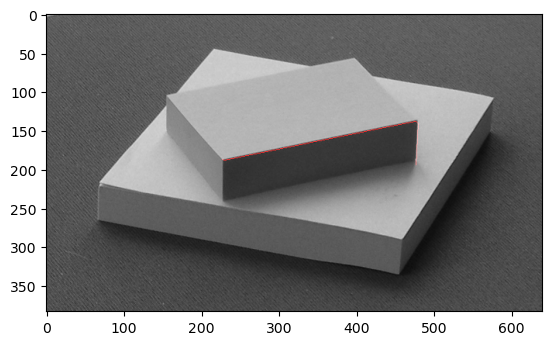

In [77]:
# @student: copy a new color img and display edge 1 and 2 in red
color_img_edge3 = copy.deepcopy(color_img)

# @student: change the color of u0 and v0 to red
color_img_edge3[v12, u12, 0] = 255

In [ ]:
# @student: apply total least squares and visualize the result
...

In [ ]:
# @student: apply the ransac algorithm and visualize the result
...